In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/'DS Capstone 2021'/

/content/drive/.shortcut-targets-by-id/1_6oH28ANdjSywY78GiDC2lKS6HM24EUV/DS Capstone 2021


In [6]:
import os
import numpy
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import json
from scipy.ndimage import binary_fill_holes
from matplotlib.path import Path
import pylab as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects
from skimage.measure import label

In [7]:
def fill_in_boundary(points, height, width):
    poly_path = Path(points)
    x, y = np.mgrid[:height, :width]
    coord = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    mask = poly_path.contains_points(coord)

    return mask.reshape(height, width)



def output_groudtruth_image_from_json(json_obj):
    # create binary array where annotated worm pixels are 1s
    shapes = json_obj["shapes"]
    height = json_obj["imageHeight"]
    width = json_obj["imageWidth"]
    truth_image = np.zeros((height, width), dtype=np.int8)
    for shape in shapes:
        points = shape["points"]
        truth_image = np.logical_or(fill_in_boundary(points, height, width), truth_image)

    return truth_image.T

def read_json(path):
    truth_dict = dict()
    for filename in os.listdir(path):
        file_lst = filename.split('.')
        if file_lst[-1] == 'json':
            with open(os.path.join(path, filename)) as json_file:
                data = json.load(json_file)
                truth_dict[".".join(file_lst[:-1])] = output_groudtruth_image_from_json(data)

    return truth_dict

In [8]:
dir = os.getcwd()

In [9]:
truth_dict = read_json(dir + '/03_annotations/1052_0/')

In [10]:
true_worm, true_n = label(truth_dict['3_synced.plate4.21-05-21.08-55_1052_0'], background=0, return_num=True)

In [11]:
true_n

28

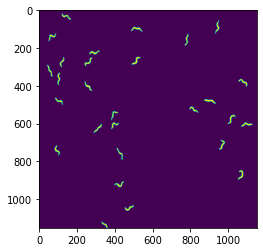

In [12]:
plt.imshow(truth_dict['3_synced.plate4.21-05-21.08-55_1052_0'])

In [13]:
def find_best_threshold(truth, image):
  return np.argmax([np.sum(cv2.threshold(image, i, 1, cv2.THRESH_BINARY_INV)[1] == truth) for i in range(255)])


In [14]:
image_grey = cv2.imread(os.path.join(dir, '03_annotations/1052_0/3_synced.plate4.21-05-21.08-55_1052_0.jpg'), 0)

In [15]:
image_grey.shape

(1152, 1152)

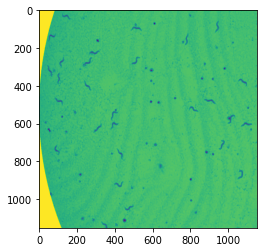

In [16]:
plt.imshow(image_grey)

In [17]:
thresh = find_best_threshold(truth_dict['3_synced.plate4.21-05-21.08-55_1052_0'], image_grey)
threshold, im_bw = cv2.threshold(image_grey, thresh, 1, cv2.THRESH_BINARY_INV)

In [18]:
print(f'new threshold {threshold}')

new threshold 172.0


In [19]:
# remove connected components smaller than certain size
remove_noise_img = remove_small_objects(im_bw.astype(bool), min_size=200, connectivity=2)

In [20]:
#label connected component
component_labels, num = label(remove_noise_img, background=0, return_num=True)

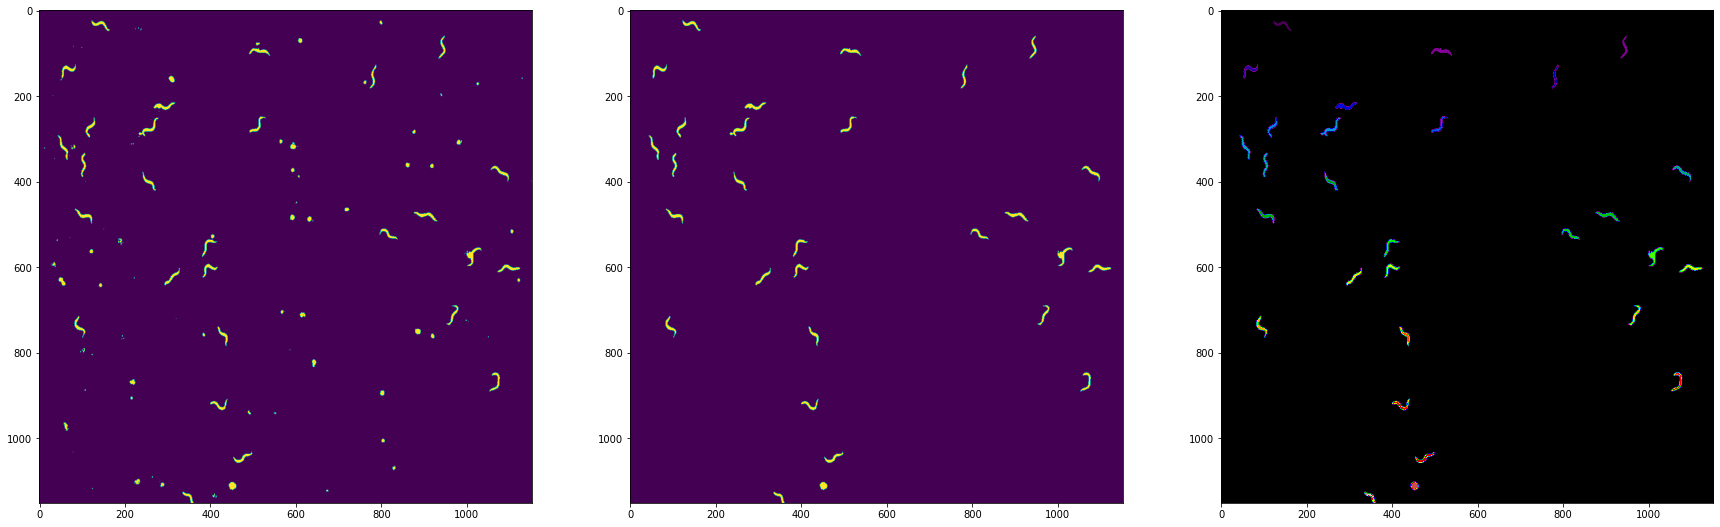

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))
ax[0].imshow(im_bw)
ax[1].imshow(remove_noise_img)
ax[2].imshow(component_labels, cmap=plt.cm.nipy_spectral)

In [22]:
print(f'number of connected componnets is {num}')

number of connected componnets is 29


In [24]:
distance = ndi.distance_transform_edt(im_bw)
coords = peak_local_max(distance, labels=im_bw)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=im_bw)

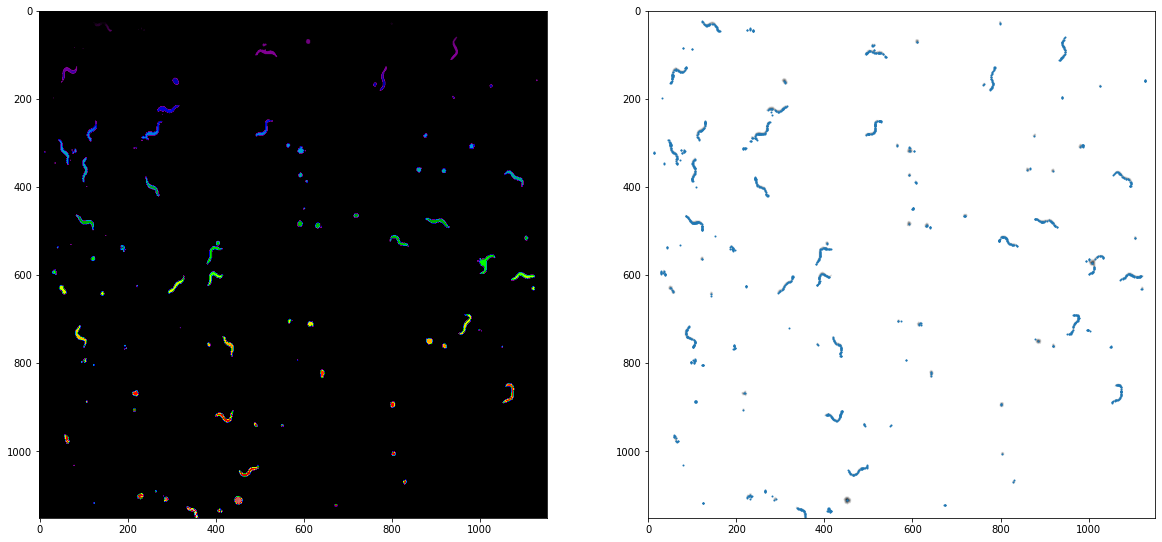

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(20,10))
axes[0].imshow(labels, cmap=plt.cm.nipy_spectral)
axes[1].imshow(-distance, cmap=plt.cm.gray)
axes[1].scatter(x=coords[:,1], y=coords[:,0], cmap=plt.cm.ocean, s=1)

In [26]:
len(np.unique(labels))

652

In [33]:
from skimage import measure
from skimage import filters

In [35]:
all_labels, num_all = measure.label(im_bw, return_num=True)
blobs_labels, num_blobs = measure.label(im_bw, background=0, return_num=True)

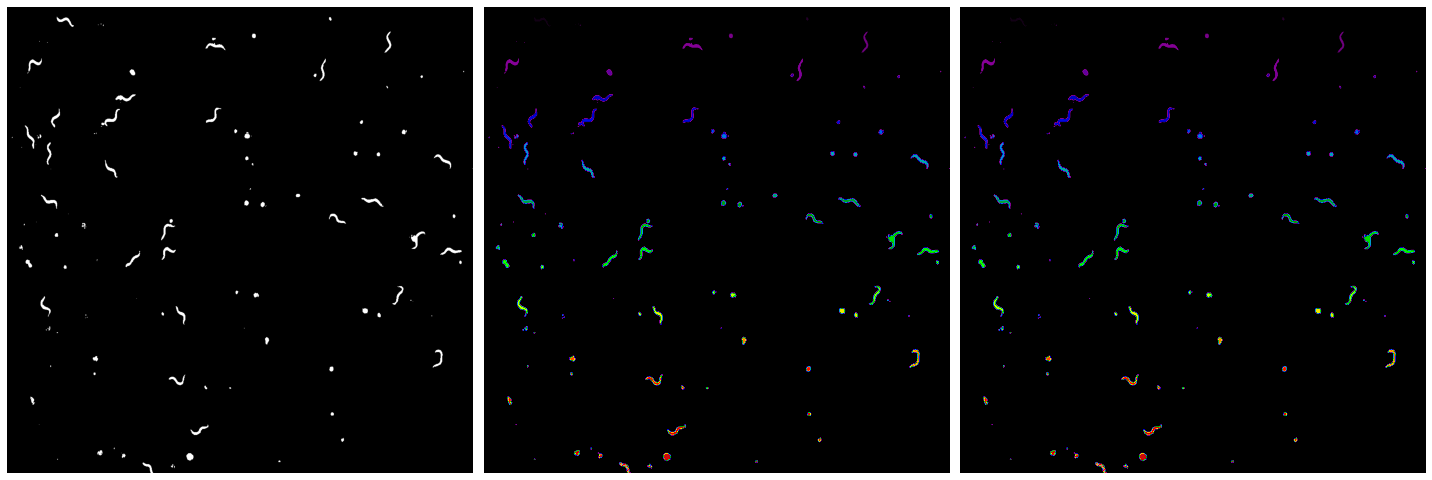

In [38]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(im_bw, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(all_labels, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(133)
plt.imshow(blobs_labels, cmap='nipy_spectral')
plt.axis('off')

plt.tight_layout()
plt.show()

In [37]:
num_all

122

In [39]:
num_blobs

122